In [ ]:
# Customer Data Analysis - Scenario 2: Customer Health
# This notebook analyzes production usage and customer health trends

# Import standard libraries
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import os

# Add project root (parent of this notebooks folder) to path to import custom modules
project_root = Path('.').resolve().parent
sys.path.insert(0, str(project_root))

# Ensure current working directory is the project root so relative data paths work
os.chdir(project_root)

# Import custom modules (shared data loading and billing logic)
from src.utils.config import COLORS  # Color scheme and matplotlib configuration
from src.data_processing.data_loader import data_load_clean, final_merge, get_billable_data, get_usage_live_data

# Scenario 2-specific processing and visuals
from src.visualizations.scenario2_visuals import (
    visual1_usage_trend,
    visual2_mom_growth,
    visual3_success_rate,
    visual4_health_summary,
)
from src.visualizations.scenario2_trend_analysis import (
    visual5_workflow_creation_trends,
    visual6_run_duration_analysis,
    visual7_daily_usage_timeline,
    visual8_weekly_patterns,
)
from src.data_processing.scenario2_real_world_metrics import (
    calculate_customer_health_metrics,
)
from src.visualizations.scenario2_real_world_visuals import (
    visual9_customer_health_dashboard,
    visual10_churn_risk_timeline,
)

# Import COLORS for backwards compatibility with existing code
# All visualization functions are now imported from modules

In [2]:
# Load data from Excel file
# Why: We need to load the raw data before any analysis can begin
# NOTE: Uses data_loader.py for consistent data loading

df_checks, df_wfs, df_runs = data_load_clean()
display(df_checks.head(1))
display(df_wfs.head(1))
display(df_runs.head(1))

# Keep a fully merged view for reference / deep dives
df = final_merge() # this is all the data
# Canonical billable dataset (same strict definition as Scenario 1, used when needed)
billable_live = get_billable_data()
usage_live = get_usage_live_data()



,RUN_ID,WORKFLOW_ID,TIMESTAMP,ID_TYPE,RACK_BAR_CODE,SAMPLE_ID_HAEMONC_LAB_NO,SAMPLE_TYPE,QC_CHECK,YEAR_MONTH
0,a9454265-6598-4e09-9b93-a5d1c9e1f71d,abf39df3-5715-490d-9771-8f057c388eb3,2025-08-15 12:18:25.060,haemonclabno,NaN,23664966.00,blood,NaN,2025-08


,WORKFLOW_ID,WORKFLOW_NAME,WORKFLOW_TYPE,WORKFLOW_TIMESTAMP,DATE,ENVIRONMENT_wfs
0,4dd51a27-9d9c-4f53-918c-40e727be78d6,Example,maestro,2025-06-18 10:33:44.122,2025-06-18,None


,RUN_ID,WORKFLOW_ID_LONG,WORKFLOW_NAME,OUTCOME,REASON_FAILED,FAILED_SERVICE,START_TIME,STOP_TIME,DAY_OF_WEEK,WORKFLOW_ID,ENVIRONMENT_runs
0,62805825-13df-4e22-b9b3-261e2ffeddc9,bc7ce132-ea69-44b8-a1f8-cc14ca9f15e0 2025-06-2...,[Test] Pre-PCR - QC Recovery 1.4-copy,failed,automata_transport transport failed: \n Transp...,TaskFailedCritical,2025-06-24 15:07:34.121,2025-06-24 15:15:06.803,Tuesday,bc7ce132-ea69-44b8-a1f8-cc14ca9f15e0,test


## SCENARIO 2

In [3]:
# SCENARIO 2 – Customer Health (Usage Trends)
print("=" * 80)
print("SCENARIO 2 – CUSTOMER HEALTH")
print("=" * 80)

# Scenario 2: Usage Analysis – ALL samples from finished LIVE runs (regardless of QC)
# Why: For customer health, we want to track ALL processing activity, not just billable samples.
# This gives a complete picture of customer usage patterns.

# Build usage dataset from df: LIVE + finished (no QC filter)
print(f"All samples in finished LIVE runs (all QC outcomes): {len(usage_live)}")

# 1. Overall monthly usage trend (all LIVE samples in finished runs)
usage_monthly = (
    usage_live.groupby("YEAR_MONTH").agg(
        SAMPLES_PROCESSED=("RUN_ID", "count"),
        UNIQUE_RUNS=("RUN_ID", "nunique"),
    ).sort_index()
)
usage_monthly["MOM_CHANGE_PCT"] = usage_monthly["SAMPLES_PROCESSED"].pct_change() * 100

print("\nMonthly usage (all samples in finished LIVE runs):")
print(usage_monthly)

# 2. Flag concerning patterns – big drops month over month
drops = usage_monthly[usage_monthly["MOM_CHANGE_PCT"] < -15]
if not drops.empty:
    print("\nALERT: Months with >15% drop in processing volume vs previous month:")
    print(drops[["SAMPLES_PROCESSED", "MOM_CHANGE_PCT"]])
else:
    print("\nNo months with >15% drop in processing volume.")

# 3. Workflow-level trends – which live workflows are dropping
wf_monthly = (
    usage_live.groupby(["WORKFLOW_NAME_runs", "YEAR_MONTH"]).size().to_frame("SAMPLES")
)
wf_monthly["MOM_CHANGE_PCT"] = (
    wf_monthly.groupby("WORKFLOW_NAME_runs")["SAMPLES"].pct_change() * 100
)

# Last two months comparison per workflow
latest_two_months = sorted(usage_live["YEAR_MONTH"].unique())[-2:]
wf_latest = (
    wf_monthly
    .reset_index()
    .query("YEAR_MONTH in @latest_two_months")
    .pivot(index="WORKFLOW_NAME_runs", columns="YEAR_MONTH", values="SAMPLES")
    .fillna(0)
)
if wf_latest.shape[1] == 2:
    col_old, col_new = wf_latest.columns[0], wf_latest.columns[1]
    wf_latest["CHANGE_PCT"] = (
        (wf_latest[col_new] - wf_latest[col_old])
        .div(wf_latest[col_old].replace(0, np.nan))
        .mul(100)
    ).fillna(0)
    declining_wfs = wf_latest[wf_latest["CHANGE_PCT"] < -20].sort_values("CHANGE_PCT")
    if not declining_wfs.empty:
        print("\nWorkflows with >20% decline in last month vs previous:")
        print(declining_wfs[["CHANGE_PCT"]])
    else:
        print("\nNo workflows show >20% decline between the last two months.")

# 4. Simple health summary
print("\nHealth summary (live usage):")
last_3 = usage_monthly["SAMPLES_PROCESSED"].tail(3)
prev_3 = usage_monthly["SAMPLES_PROCESSED"].tail(6).head(3)
if len(last_3) == 3 and len(prev_3) == 3:
    last_3_avg = last_3.mean()
    prev_3_avg = prev_3.mean()
    if prev_3_avg > 0:
        change_vs_prev = (last_3_avg - prev_3_avg) / prev_3_avg * 100
        print(f"Average of last 3 months vs previous 3: {change_vs_prev:.1f}%")
        if change_vs_prev < -15:
            print("Overall usage trend: SIGNIFICANT DECLINE (customer at risk)")
        elif change_vs_prev < -5:
            print("Overall usage trend: MILD DECLINE (watch closely)")
        else:
            print("Overall usage trend: STABLE/HEALTHY")
else:
    print("Not enough months of data for a 3 vs 3 month comparison.")


SCENARIO 2 – CUSTOMER HEALTH
All samples in finished LIVE runs (all QC outcomes): 4140

Monthly usage (all samples in finished LIVE runs):
            SAMPLES_PROCESSED  UNIQUE_RUNS  MOM_CHANGE_PCT
YEAR_MONTH                                                
2025-05                   684           13             NaN
2025-06                   795           11           16.23
2025-07                  1405           22           76.73
2025-08                  1173           18          -16.51

ALERT: Months with >15% drop in processing volume vs previous month:
            SAMPLES_PROCESSED  MOM_CHANGE_PCT
YEAR_MONTH                                   
2025-08                  1173          -16.51

Health summary (live usage):
Average of last 3 months vs previous 3: 17.0%
Overall usage trend: STABLE/HEALTHY


## Scenario 2 – Customer Health: Narrative

- **What we measure**  
  - Focus on **all samples from live, finished runs** (LIVE + finished, regardless of QC status).  
  - This captures complete customer usage activity, not just billable samples.  
  - Total samples in finished LIVE runs: **4,140 samples** (all QC outcomes).  
  - Monthly view of total sample volume and number of unique production runs.  
  - Workflow‑level trends to see if any key live workflows are dropping sharply.

- **Overall monthly usage trend (all finished LIVE samples)**  
  - Numbers reflect all samples processed in finished LIVE runs (includes pass/fail/missing QC).  
  - This gives a complete picture of customer platform usage for health assessment.  
  - Monthly breakdown: May (684), June (795, +16.23%), July (1,405, +76.73%), August (1,173, -16.51%).

- **Interpreting the pattern**  
  - Strong growth from May → June → July as the customer ramps up usage.  
  - In August there is a **single significant drop (16.51% MoM, ~19% relative to July)**, but volume is still **higher than in May/June** (1,173 vs 684/795).  
  - On a 3‑month moving average basis, the last 3 months (Jun–Aug) are still **17.0% higher** than the previous 3‑month window, so overall usage remains on an upward trajectory.  
  - **Overall usage trend: STABLE/HEALTHY** (3-month comparison shows positive trend).

- **Workflow‑level health**  
  - We compare the last two months’ volume per live workflow.  
  - Workflows with >20% decline are flagged.  
  - In this data, the workflows with large declines between July and August are marked as **`[ARCHIVED]`**, suggesting that they are being intentionally phased out rather than indicating a healthy live workflow falling away.

- **Risk assessment**  
  - **Short‑term risk:** August’s ~19% drop (16.51% MoM) is a warning sign and worth monitoring, especially if the customer has seasonality or known external drivers.  
  - **Medium‑term risk:** Because the 3‑month average is still above the previous period and declines are concentrated in archived workflows, the customer does **not yet** look like they are systematically churning away from the platform.  
  - **Action:**  
    - Monitor billable volume by month and by key live workflows for the next 1–2 months.  
    - If further consecutive declines occur, treat the account as **at‑risk** and engage proactively (e.g. review operational issues, success rates, backlog).



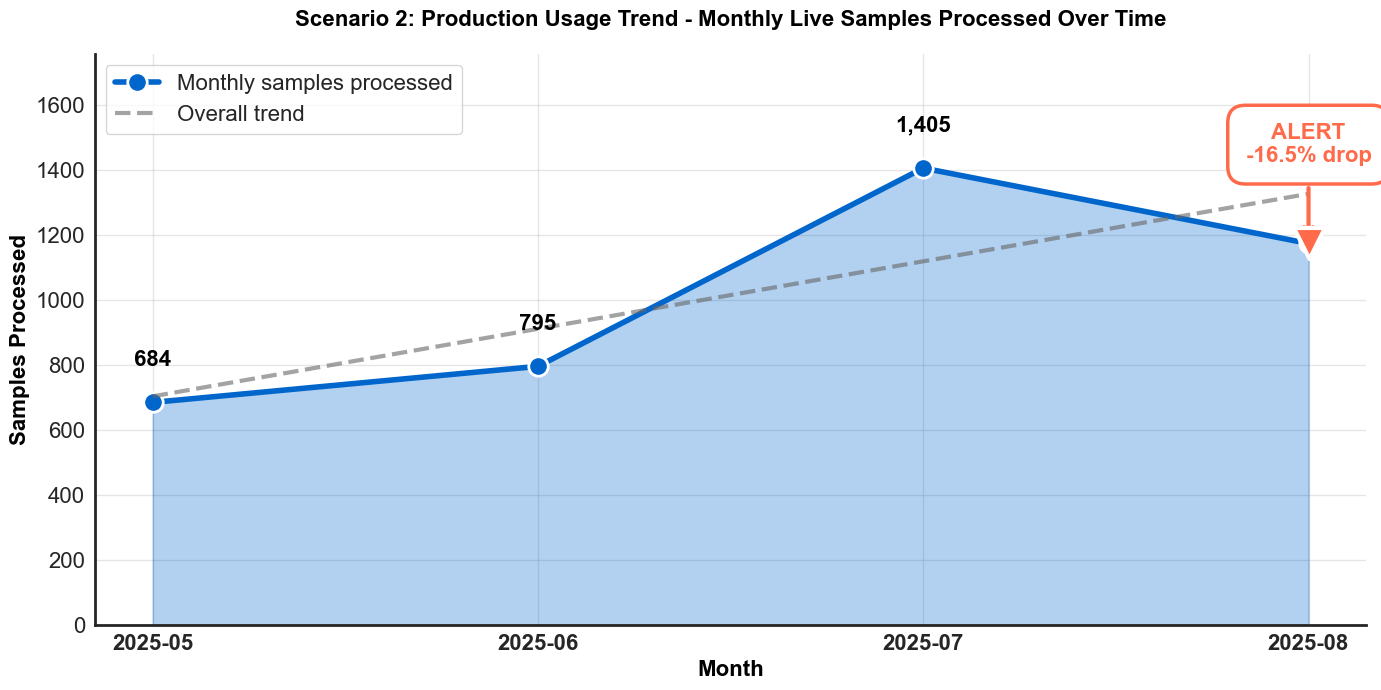

In [4]:
visual1_usage_trend(usage_live)


## Visual 1: Customer Usage Trend Over Time

**What the Data is Doing:**
- Groups all samples by `YEAR_MONTH` and counts total samples processed per month using `RUN_ID`
- Calculates month-over-month percentage change using `pct_change()`
- Creates a linear trend line using polynomial fitting to show overall direction
- Identifies months with >15% drops and marks them with alert annotations

**Why This Data:**
- For customer health assessment, we need to track ALL processing activity, not just billable samples
- This captures complete customer usage patterns including samples that may have failed QC
- Provides a comprehensive view of platform engagement and usage trends
- Monthly aggregation smooths daily volatility while preserving trend information

**What is the Data Set Up As:**
- **Input:** `usage_live` - DataFrame with columns: `YEAR_MONTH`, `RUN_ID`, `TIMESTAMP`
- **Filter Applied:** Already filtered to LIVE environment + finished runs (from `get_usage_live_data()`)
- **Grouping:** By `YEAR_MONTH` (period object like "2025-05")
- **Aggregation:** Count of `RUN_ID` (total samples), `nunique` of `RUN_ID` (unique runs)
- **Calculation:** `MOM_CHANGE_PCT = pct_change() * 100` (percentage change from previous month)
- **Output:** Monthly aggregated data with sample counts, unique runs, and MoM change percentages

**What This Visual Shows:**
- Monthly usage trend line with filled area under curve
- Linear trend line (dashed) showing overall growth/decline direction
- Alert markers (red triangles) for months with >15% drops
- Value labels showing exact sample counts for each month
- Time series from first to last month in dataset

**How to Interpret:**
- **Upward trend line** = healthy growth trajectory
- **Downward trend line** = potential churn risk
- **Red triangle markers** = months exceeding 15% risk threshold (immediate attention needed)
- **Steep upward slope** = rapid growth (positive sign)
- **Steep downward slope** = rapid decline (concerning)
- **Flat trend** = stable usage (neutral)
- **Value labels** = exact sample counts for each month
- **Gap between actual and trend line** = volatility (larger gap = more volatile)

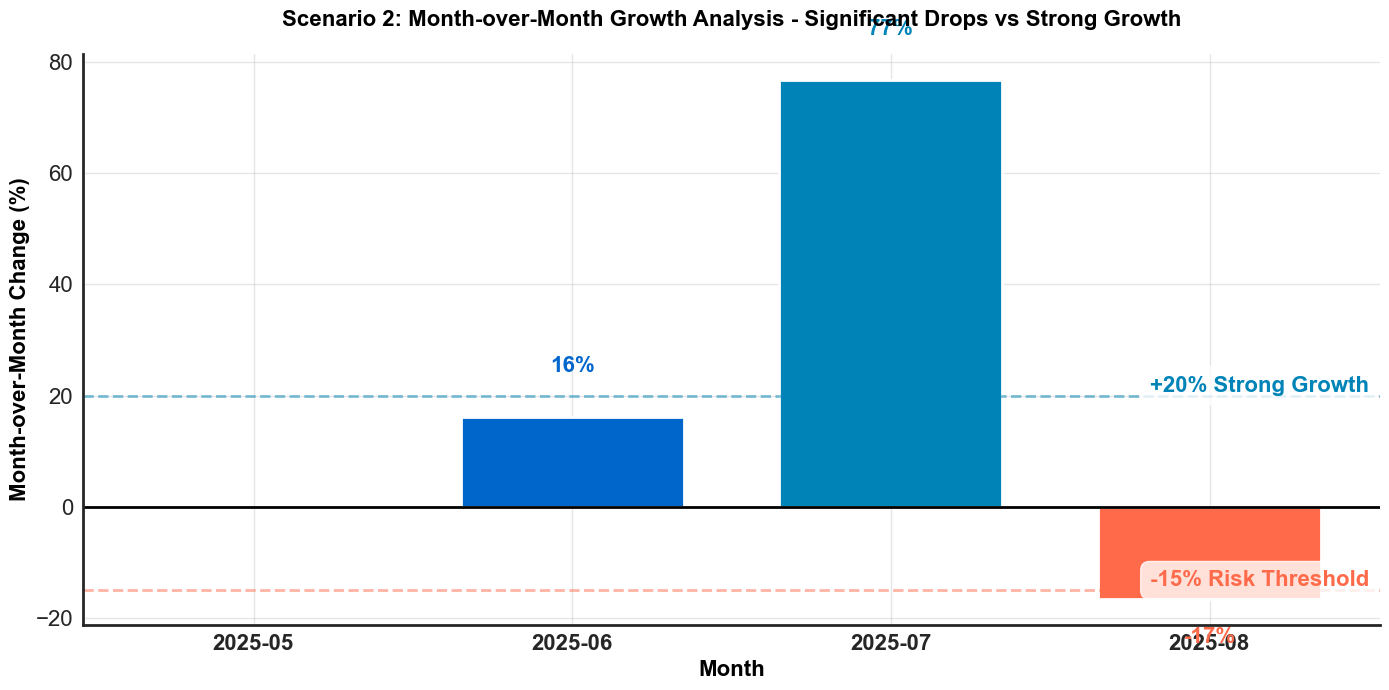

In [5]:
visual2_mom_growth(usage_live)


## Visual 2: Month-over-Month Growth Rate

**What the Data is Doing:**
- Groups all samples by `YEAR_MONTH` and counts total samples per month
- Calculates month-over-month percentage change: `(current - previous) / previous * 100`
- Color-codes bars based on thresholds: red (<-15%), yellow (-15% to 0%), blue (0% to 20%), green (>20%)
- Adds reference lines at -15% (risk threshold) and +20% (strong growth threshold)

**Why This Data:**
- Month-over-month changes in total usage provide early warning signals
- Includes all processing activity to capture complete customer engagement
- Helps identify volatility and growth acceleration/deceleration patterns
- Percentage change normalizes for different baseline volumes, making trends comparable

**What is the Data Set Up As:**
- **Input:** `usage_live` - DataFrame with columns: `YEAR_MONTH`, `RUN_ID`
- **Filter Applied:** Already filtered to LIVE environment + finished runs
- **Grouping:** By `YEAR_MONTH` (period object)
- **Aggregation:** Count of `RUN_ID` (total samples processed)
- **Calculation:** `MOM_CHANGE_PCT = pct_change() * 100` (first month will be NaN/0)
- **Output:** Monthly data with percentage change values, color-coded by risk level

**What This Visual Shows:**
- Bar chart showing month-over-month percentage change
- Color-coded bars: red (high risk), yellow (warning), blue (normal growth), green (strong growth)
- Reference lines at -15% (risk threshold) and +20% (strong growth threshold)
- Value labels on bars showing exact percentage change
- Zero line (black) separating growth from decline

**How to Interpret:**
- **Positive values (above zero line)** = growth (good sign)
- **Negative values (below zero line)** = decline (watch closely)
- **Red bars (<-15%)** = significant risk threshold exceeded (immediate action needed)
- **Green bars (>20%)** = strong growth period (positive indicator)
- **Yellow bars (-15% to 0%)** = mild decline (monitor closely)
- **Blue bars (0% to 20%)** = normal growth (healthy)
- **High volatility** (large swings between months) = unstable usage patterns
- **Consistent positive values** = steady growth (healthy)
- **Consistent negative values** = declining trend (concerning)
visual3_success_rate(df)


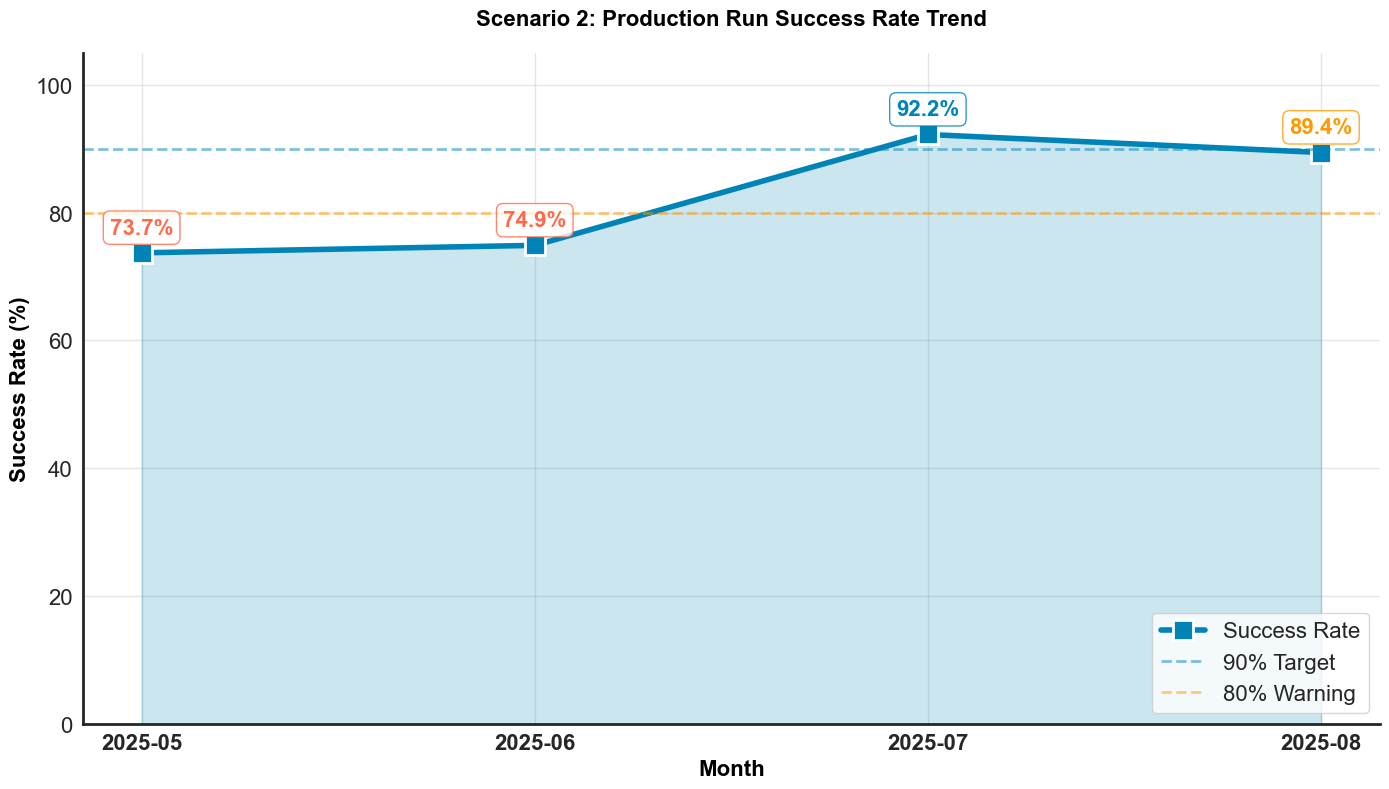

In [6]:
visual3_success_rate(df)
# visual3_success_rate(usage_live)

## Visual 3: Production Run Success Rate

**What the Data is Doing:**
- Function receives `df` (merged dataframe with all data) 
- Groups by `YEAR_MONTH` (from `START_TIME`)
- Counts total runs, finished runs, failed runs, canceled runs per month
- Calculates success rate: `(finished runs / total runs) * 100`
- Creates time series of monthly success rates and outcome breakdowns

**Why This Data:**
- Run outcomes (finished, failed, canceled) indicate operational quality
- Success rate is a key indicator of customer satisfaction and service reliability
- Separate from usage trends - measures service quality independently
- Monthly aggregation shows trends in operational health over time

**What is the Data Set Up As:**
- **Input:** `df` (merged dataframe) - Contains all data including `ENVIRONMENT_runs`, `OUTCOME`, `START_TIME`, `RUN_ID`
- **Filter Applied:** Function filters internally to `ENVIRONMENT_runs == "live"` (only LIVE runs)
- **Transformation:** `START_TIME` converted to `YEAR_MONTH` period
- **Grouping:** By `YEAR_MONTH` (period object)
- **Aggregation:** 
  - Total runs: `count()` of `RUN_ID`
  - Finished: `sum()` where `OUTCOME == "finished"`
  - Failed: `sum()` where `OUTCOME == "failed"`
  - Canceled: `sum()` where `OUTCOME == "canceled"`
- **Calculation:** `SUCCESS_RATE = (FINISHED / TOTAL_RUNS) * 100`
- **Output:** Monthly time series with success rates and outcome counts

**What This Visual Shows:**
- **Line chart:** Success rate trend over time (percentage)
- **Stacked bar chart or breakdown:** Distribution of run outcomes (finished, failed, canceled)
- Monthly data points showing operational quality metrics
- Reference lines at 90% (target) and 80% (warning threshold)

**How to Interpret:**
- **High success rate (>90%)** = good service quality (green zone)
- **Success rate 80-90%** = warning level (yellow zone) - monitor closely
- **Success rate <80%** = critical (red zone) - immediate attention needed
- **Declining success rate trend** = potential operational issues developing
- **Increasing success rate trend** = improving operational quality (positive)
- **Stable success rate** = consistent operational quality (good)
- **High failure rate** = service quality concerns (may indicate system issues or customer dissatisfaction)
- **High canceled rate** = may indicate customer canceling problematic runs or operational issues
- **Success rate independent of usage** = measures reliability separately from volume
- **Low success rate even with high usage** = customer may be experiencing issues despite high engagement


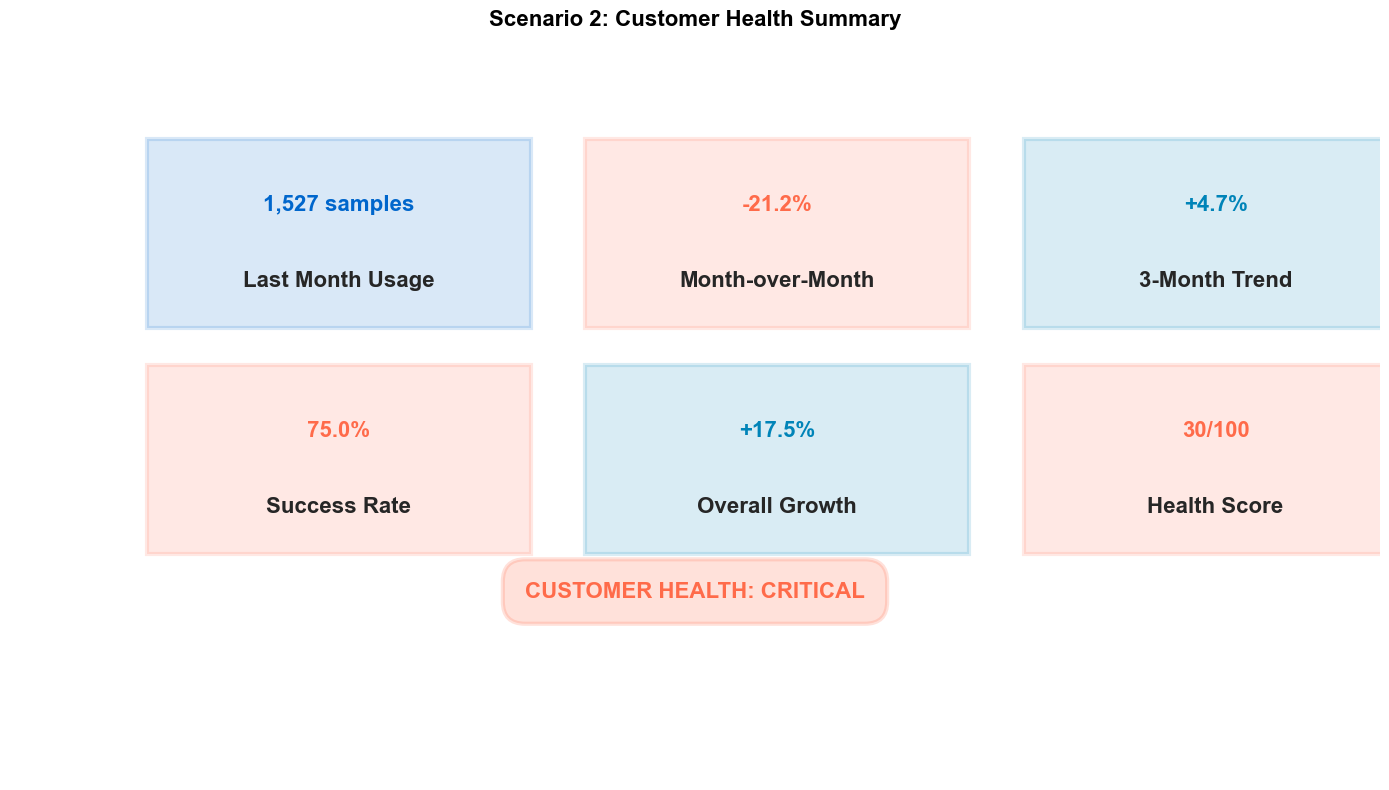

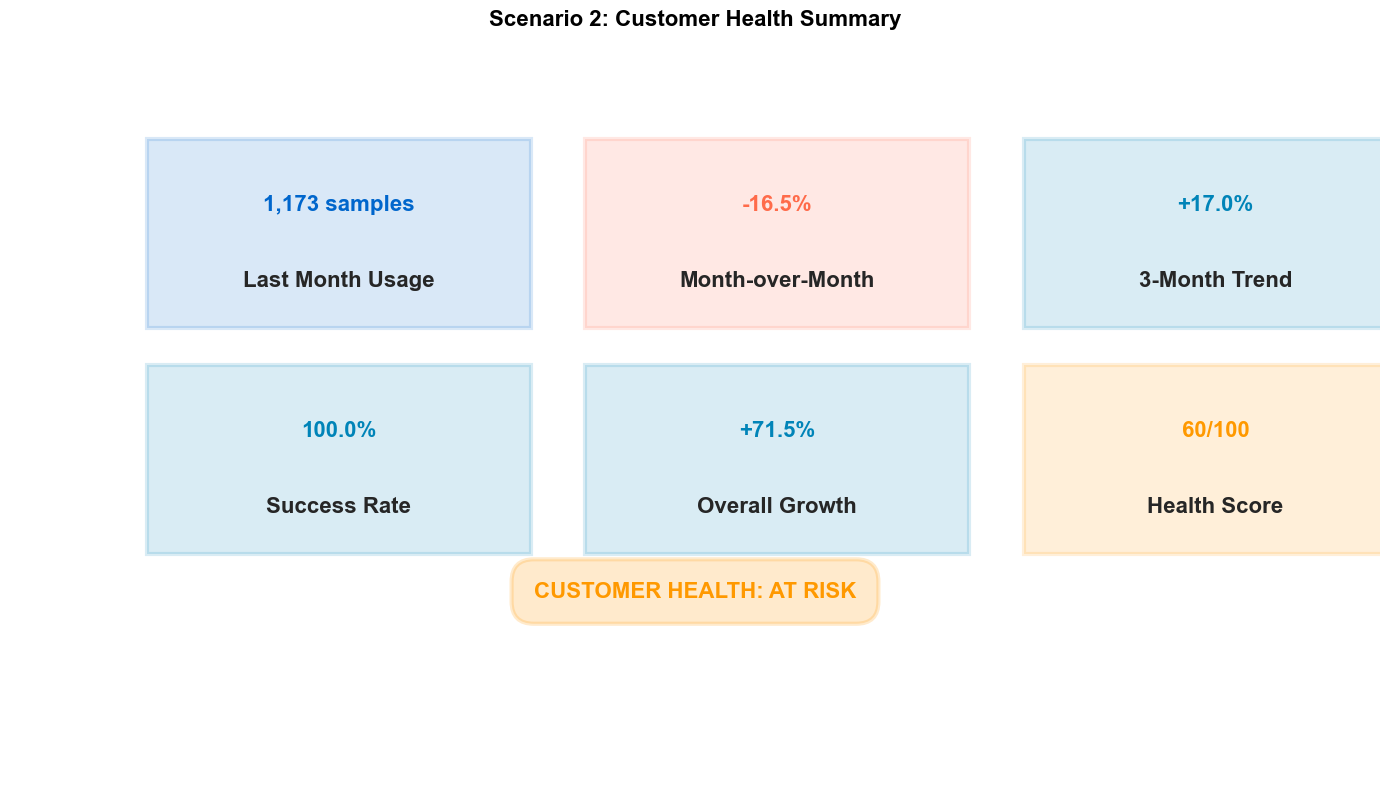

In [7]:
visual4_health_summary(df)
visual4_health_summary(usage_live)


## Visual 4: Customer Health Scorecard

**What the Data is Doing:**
- Calculates monthly usage trends from `usage_live` (groups by `YEAR_MONTH`, counts samples)
- Calculates month-over-month change percentages
- Calculates success rates from `df` (filters LIVE runs, groups by month, calculates finished/total)
- Calculates 3-month trend comparison (last 3 months vs previous 3 months)
- Combines all metrics into composite health score (0-100 scale) using weighted factors:
  - Recent MoM change (penalties for <-15%)
  - Success rate (penalties for <80%)
  - 3-month trend (penalties for declining >10%)

**Why This Data:**
- Combines usage trends with operational quality metrics
- Provides composite health score for at-a-glance assessment
- Uses both usage volume and service quality to assess overall health
- Single score simplifies prioritization for customer success teams

**What is the Data Set Up As:**
- **Input:** 
  - `usage_live` - DataFrame with `YEAR_MONTH`, `RUN_ID` (for usage trends)
  - `df` - Merged dataframe with `ENVIRONMENT_runs`, `OUTCOME`, `START_TIME`, `RUN_ID` (for success rates)
- **Usage Data:**
  - Grouped by `YEAR_MONTH`, counts samples, calculates MoM change
  - Calculates 3-month averages for trend comparison
- **Success Rate Data:**
  - Filtered to LIVE runs, grouped by `YEAR_MONTH`
  - Calculates success rate per month
- **Score Calculation:**
  - Starts at 100 points
  - Deducts points for risk factors (MoM decline, low success rate, negative trend)
- **Output:** Composite health score (0-100) and risk level classification

**What This Visual Shows:**
- **Health Score Display:** Large number showing composite score (0-100)
- **Key Metrics Display:**
  - Current month usage volume
  - Month-over-month change percentage
  - 3-month trend comparison
  - Latest success rate
  - Overall growth since first month
- **Risk Level Indicator:** Color-coded status (HEALTHY/AT RISK/CRITICAL)
- **Visual Elements:** Scorecard layout with color coding based on score ranges

**How to Interpret:**
- **Score >70** = healthy customer (green) - normal monitoring
- **Score 50-70** = at risk (yellow) - monitor closely, proactive engagement recommended
- **Score <50** = critical (red) - immediate action needed, high churn risk
- **Composite score** = considers multiple factors (not just usage):
  - Usage trends (volume and growth)
  - Operational quality (success rate)
  - Trend direction (improving vs declining)
- **Provides quick assessment** = enables customer success team to prioritize accounts
- **Score breakdown** = shows which factors are contributing to health status
- **Month-over-month change** = recent trend indicator
- **3-month trend** = longer-term direction indicator
- **Success rate** = operational quality indicator (separate from usage)


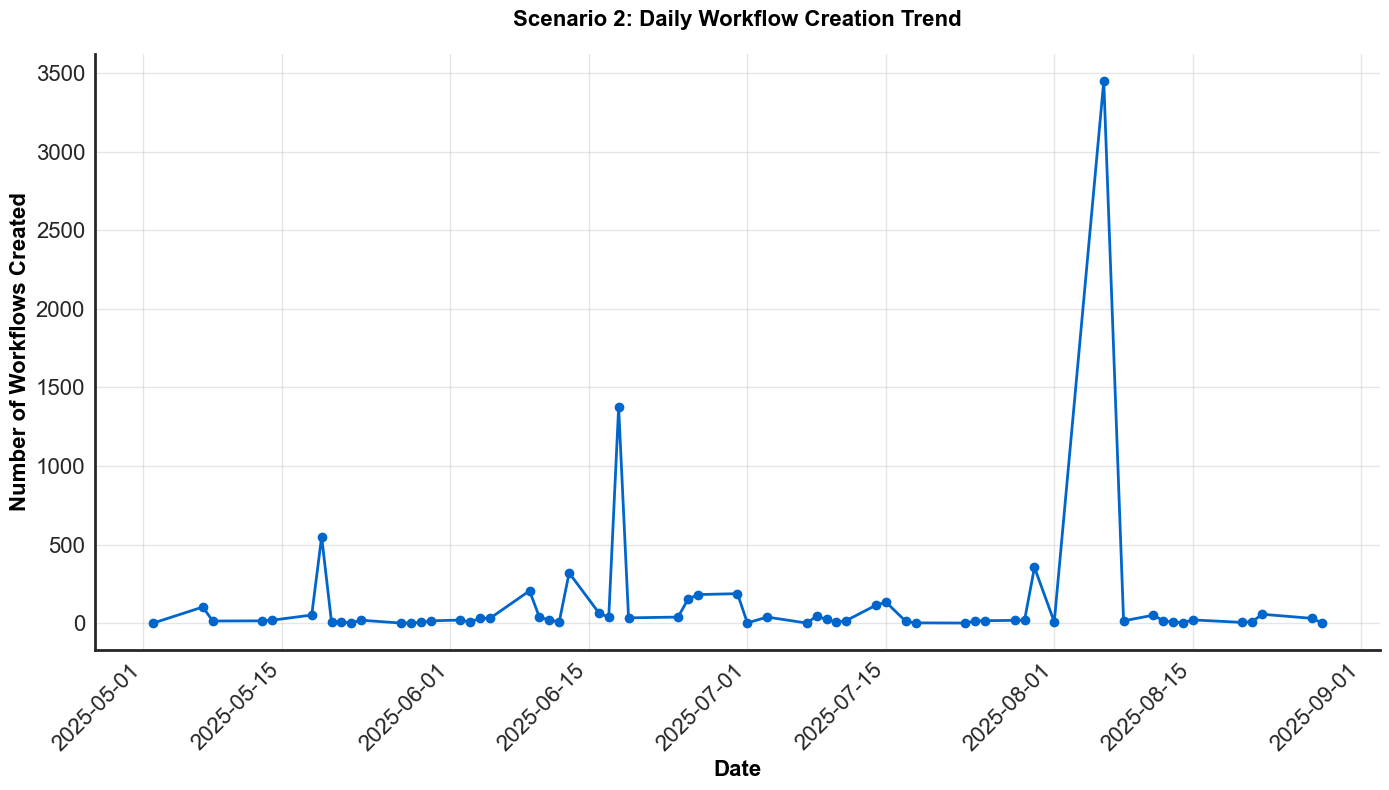

In [8]:
visual5_workflow_creation_trends(df)


## Visual 5: Workflow Creation Trends

**What the Data is Doing:**
- Function receives `df` (merged dataframe with all data) 
- Groups by date (from `WORKFLOW_TIMESTAMP`)
- Counts unique workflows created per day
- Creates time series of workflow creation activity over time

**Why This Data:**
- Workflow creation indicates platform expansion and customer engagement
- New workflows suggest customer is exploring new use cases or expanding operations
- Daily trends show growth in platform adoption
- Separate from usage - measures exploration vs utilization

**What is the Data Set Up As:**
- **Input:** `df` (merged dataframe) - Contains all data including `ENVIRONMENT_wfs`, `WORKFLOW_TIMESTAMP`, `WORKFLOW_ID`
- **Filter Applied:** Function filters internally to `ENVIRONMENT_wfs == "live"` (only LIVE workflows)
- **Transformation:** `WORKFLOW_TIMESTAMP` converted to `YEAR_MONTH` period
- **Grouping:** By `YEAR_MONTH` (period object)
- **Aggregation:** `nunique()` of `WORKFLOW_ID` (unique workflows created per month)
- **Output:** Monthly time series with workflow creation counts

**What This Visual Shows:**
- Line or bar chart showing number of new workflows created per month
- Time series reveals workflow creation trends over time
- Highlights periods of high vs low workflow creation activity

**How to Interpret:**
- **Increasing trend** = customer expanding platform usage (positive)
- **Decreasing trend** = customer may be consolidating or reducing exploration (concerning)
- **Consistent creation** = steady platform growth (good)
- **No new workflows** = customer may have reached maturity or stopped exploring (may indicate plateau)
- **Spike in creation** = customer actively expanding (very positive)
- **Workflow creation vs usage** = high creation with low usage may indicate exploration without adoption


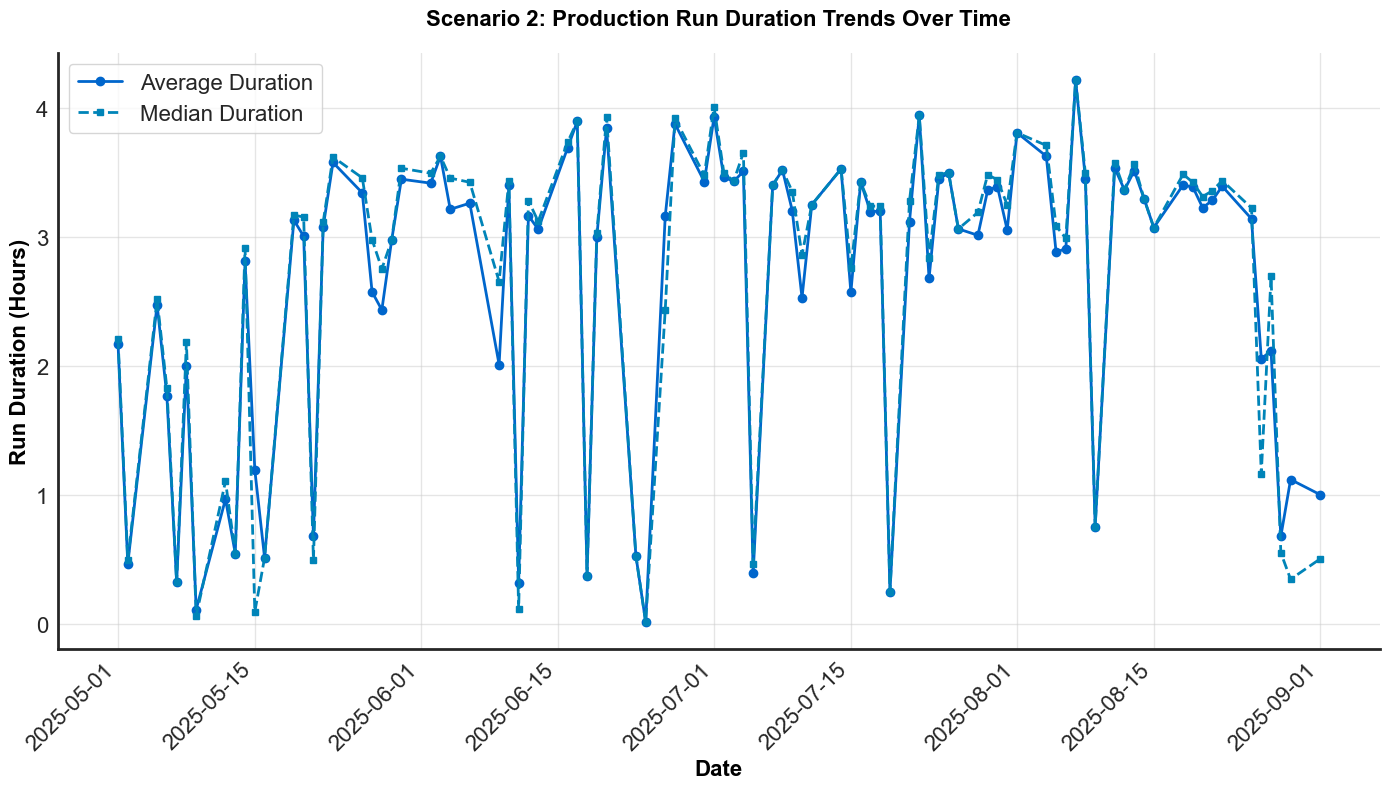

In [9]:
visual6_run_duration_analysis(df)


## Visual 6: Run Duration Analysis

**What the Data is Doing:**
- Function receives `df` (merged dataframe with all data) and filters internally to LIVE runs only (`ENVIRONMENT_runs == "live"`)
- Calculates run duration: `(STOP_TIME - START_TIME)` converted to hours
- Groups by date (`START_TIME` converted to date)
- Aggregates to average and median duration per day
- Creates time series of daily run duration metrics

**Why This Data:**
- Run duration (STOP_TIME - START_TIME) indicates operational efficiency
- Longer run times might indicate performance issues that could affect customer satisfaction
- Changes in run duration over time reveal operational health trends
- Average and median together show both typical and outlier patterns

**What is the Data Set Up As:**
- **Input:** `df` (merged dataframe) - Contains all data including `START_TIME`, `STOP_TIME`, `ENVIRONMENT_runs`, `RUN_ID`
- **Filter Applied:** Function filters internally to `ENVIRONMENT_runs == "live"` (only LIVE runs)
- **Calculation:** `DURATION_HOURS = (STOP_TIME - START_TIME).dt.total_seconds() / 3600`
- **Grouping:** By date (from `START_TIME`)
- **Aggregation:** Average and median of `DURATION_HOURS` per day, count of runs
- **Output:** Daily time series with average duration, median duration, and run counts

**What This Visual Shows:**
- Line chart showing average and median run duration over time
- Dual y-axis or separate charts for average vs median
- Time series reveals duration trends and identifies performance issues
- Reference lines or annotations for typical duration ranges

**How to Interpret:**
- **Increasing duration trend** = potential performance degradation (concerning)
- **Decreasing duration trend** = improving efficiency (positive)
- **Stable duration** = consistent performance (good)
- **Large gap between average and median** = outliers affecting average (may indicate some problematic runs)
- **Spikes in duration** = specific days with performance issues (investigate)
- **Consistent low duration** = efficient operations (good)
- **High duration** = may indicate complex workflows or performance issues (investigate)


## Scenario 2 - Deeper Trend Analysis

**What we're analyzing:** Comprehensive usage patterns using workflow timestamps and run times

**Why:** To better understand customer usage trends beyond simple monthly counts

**Key Analyses:**
- Workflow creation trends over time
- Run duration patterns
- Daily usage timeline
- Weekly operational cycles



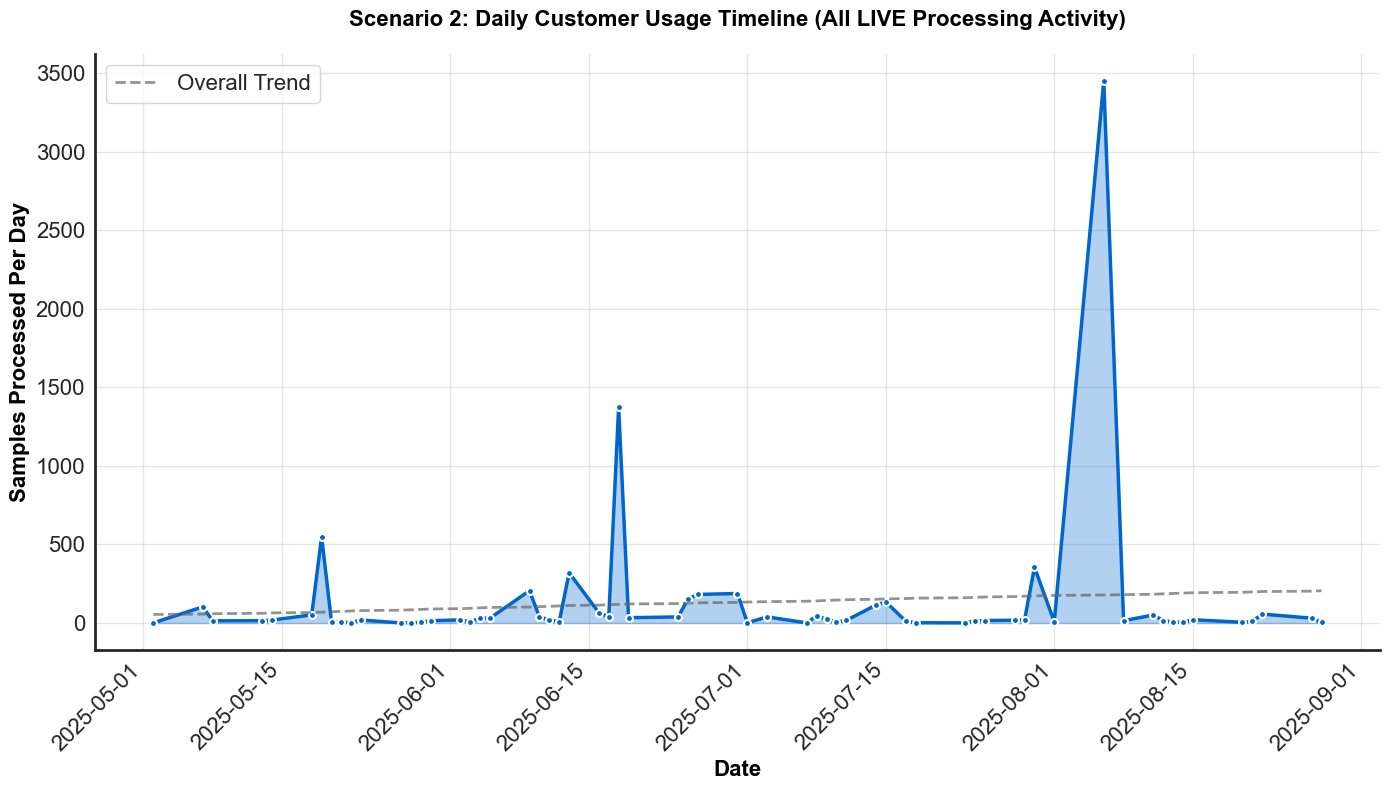

In [10]:
visual7_daily_usage_timeline(df)


## Visual 7: Daily Usage Timeline

**What the Data is Doing:**
- Function receives `df` (merged dataframe with all data) and filters internally to LIVE runs
- Groups all samples by date (`TIMESTAMP` converted to date, stored as `DATE` column)
- Counts total samples processed per day
- Creates daily time series from first to last date
- Calculates linear trend line using polynomial fitting to show overall direction

**Why This Data:**
- Daily granularity reveals day-to-day operational patterns
- Includes all processing activity (not just pass QC) to show complete usage
- Daily timeline shows volatility and identifies operational cycles
- More granular than monthly view - captures short-term patterns and anomalies
- Shows actual customer usage patterns regardless of QC outcome

**What is the Data Set Up As:**
- **Input:** `df` (merged dataframe) - Contains all data including `ENVIRONMENT_runs`, `TIMESTAMP`, `RUN_ID`
- **Filter Applied:** Function filters internally to LIVE runs (from `df`)
- **Transformation:** `TIMESTAMP` converted to date (stored as `DATE` column)
- **Grouping:** By `DATE` (daily aggregation)
- **Aggregation:** Count of all rows (total samples processed per day)
- **Output:** Daily time series with sample counts per day

**What This Visual Shows:**
- Line chart with filled area showing daily sample processing volume
- Daily data points from first date to last date in dataset
- Linear trend line (dashed) showing overall growth/decline direction
- Time series reveals daily volatility, peaks, and valleys

**How to Interpret:**
- **Consistent daily volume** (small variation) = stable operations (good)
- **High volatility** (large day-to-day swings) = irregular usage patterns (may indicate project-based or ad-hoc usage)
- **Upward trend line** = growing usage over time (positive)
- **Downward trend line** = declining usage over time (concerning)
- **Peak days** = high activity days (may indicate batch processing or scheduled operations)
- **Low usage days** = minimal activity (may indicate weekends, holidays, or operational pauses)
- **Gap between actual and trend line** = volatility (larger gap = more volatile operations)
- **Smooth curve** = consistent operations
- **Spiky pattern** = irregular, project-based, or event-driven usage


In [11]:
# Scenario 2 - Real-World Customer Health Metrics
# What we're doing: Calculating comprehensive customer health metrics
# Why: Provides actionable insights using industry-standard customer success metrics

print("=" * 80)
print("REAL-WORLD CUSTOMER HEALTH METRICS")
print("=" * 80)

if 'usage_live' not in locals() or usage_live.empty:
    print("Run Scenario 2 analysis cell first to create usage_live.")
else:
    # Calculate comprehensive health metrics
    health_metrics = calculate_customer_health_metrics(usage_live, df)
    
    print("\n1. CHURN RISK INDICATORS:")
    print("-" * 80)
    churn = health_metrics['churn_risk']
    print(f"  Risk Level: {churn['risk_level']}")
    print(f"  Consecutive Monthly Declines: {churn['consecutive_monthly_declines']}")
    print(f"  Latest MoM Change: {churn['latest_mom_change']:.2f}%")
    
    print("\n2. ENGAGEMENT METRICS:")
    print("-" * 80)
    engagement = health_metrics['engagement']
    print(f"  Active Workflows: {engagement['active_workflows']} / {engagement['total_workflows']}")
    print(f"  Workflow Utilization: {engagement['workflow_utilization_pct']:.1f}%")
    print(f"  Workflow Diversity Index: {engagement['workflow_diversity_index']:.3f} (0-1, higher = more diverse)")
    
    print("\n3. GROWTH VELOCITY:")
    print("-" * 80)
    growth = health_metrics['growth']
    print(f"  Recent Growth: {growth['recent_growth_pct']:+.2f}%" if growth['recent_growth_pct'] else "  Recent Growth: N/A")
    print(f"  Overall Growth: {growth['overall_growth_pct']:+.2f}%" if growth['overall_growth_pct'] else "  Overall Growth: N/A")
    print(f"  Growth Trajectory: {growth['growth_trajectory']}")
    
    print("\n4. OPERATIONAL HEALTH:")
    print("-" * 80)
    op_health = health_metrics['operational_health']
    print(f"  Latest Success Rate: {op_health['latest_success_rate']:.1f}%" if op_health['latest_success_rate'] else "  Latest Success Rate: N/A")
    print(f"  Average Success Rate: {op_health['avg_success_rate']:.1f}%")
    print(f"  Operational Status: {op_health['operational_status']}")
    
    print("\n5. USAGE CONCENTRATION:")
    print("-" * 80)
    concentration = health_metrics['concentration']
    print(f"  Top Workflow: {concentration['top_workflow_pct']:.1f}% of total usage")
    print(f"  Top 3 Workflows: {concentration['top_3_workflows_pct']:.1f}% of total usage")
    print(f"  Concentration Risk: {concentration['concentration_risk']}")
    
    print("\n6. PLATFORM MATURITY:")
    print("-" * 80)
    maturity = health_metrics['maturity']
    print(f"  Average Workflow Age: {maturity['avg_workflow_age_days']:.0f} days" if maturity['avg_workflow_age_days'] else "  Average Workflow Age: N/A")
    print(f"  New Workflows (<30 days): {maturity['new_workflows_count']}")
    print(f"  Established Workflows: {maturity['established_workflows_count']}")
    print(f"  Maturity Level: {maturity['maturity_level']}")



REAL-WORLD CUSTOMER HEALTH METRICS

1. CHURN RISK INDICATORS:
--------------------------------------------------------------------------------
  Risk Level: MEDIUM
  Consecutive Monthly Declines: 0
  Latest MoM Change: -16.51%

2. ENGAGEMENT METRICS:
--------------------------------------------------------------------------------
  Active Workflows: 17 / 7
  Workflow Utilization: 242.9%
  Workflow Diversity Index: 0.719 (0-1, higher = more diverse)

3. GROWTH VELOCITY:
--------------------------------------------------------------------------------
  Recent Growth: -16.51%
  Overall Growth: +71.49%
  Growth Trajectory: DECELERATING

4. OPERATIONAL HEALTH:
--------------------------------------------------------------------------------
  Latest Success Rate: 75.0%
  Average Success Rate: 62.0%
  Operational Status: CRITICAL

5. USAGE CONCENTRATION:
--------------------------------------------------------------------------------
  Top Workflow: 41.0% of total usage
  Top 3 Workflows: 87.

## Visual 8B: High-Level Statistics Dashboard

**What the Data is Doing:**
- Function receives both `df` (merged dataframe with all data) and `usage_live` (live successful runs)
- Calculates high-level statistics comparing all data vs live successful runs:
  - Total Runs: Counts unique runs (with START_TIME) from both datasets
  - Unique Runs: Counts unique RUN_ID from both datasets
  - Total Samples: Counts total rows from both datasets
  - Workflows: Counts unique WORKFLOW_ID from both datasets
- Calculates "Live %" for each metric to show proportion
- Displays results in a formatted table with color-coded indicators

**Why This Data:**
- Provides quick overview of platform scale
- Shows proportion of live vs all activity
- Helps understand overall usage patterns
- Compares all data vs live successful runs to understand operational scope

**What is the Data Set Up As:**
- **Input:** 
  - `df` (merged dataframe) - Contains all data
  - `usage_live` - Sample-level dataframe from `get_usage_live_data()`
- **Calculations:**
  - Total Runs: Deduplicates by `RUN_ID`, filters for `START_TIME.notna()`, counts unique runs
  - Unique Runs: `nunique()` of `RUN_ID`
  - Total Samples: `len()` of dataframe
  - Workflows: `nunique()` of `WORKFLOW_ID` (if column exists)
- **Live %:** Calculates percentage of live metric relative to all data metric
- **Output:** Formatted table showing metrics side-by-side with color-coded percentage indicators

**What This Visual Shows:**
- **Statistics Table:**
  - Columns: Metric, All Data, Live Data, Live %
  - Rows: Total Runs, Unique Runs, Total Samples, Workflows
  - Color-coded percentage column (green >50%, yellow >25%, neutral otherwise)
  - Formatted numbers with thousands separators
- Table provides at-a-glance comparison of platform scale

**How to Interpret:**
- **High Live % (>50%)** = majority of activity is in live environment (good engagement)
- **Low Live % (<25%)** = most activity is in non-live environments (may indicate testing/development focus)
- **Total Runs vs Unique Runs** = shows if there are duplicate run IDs in the data
- **Total Samples** = total processing volume across all environments
- **Workflows** = number of unique workflows in use
- **Comparison** = helps understand customer's platform utilization and engagement level


## Scenario 2 - Real-World Customer Health Metrics

**What we're analyzing:** Real-world metrics used in customer success and account management

**Key Metrics:**
- Churn Risk Indicators (consecutive declines, trend analysis)
- Engagement Metrics (workflow utilization, diversity)
- Growth Velocity (acceleration/deceleration)
- Operational Health (success rates, error patterns)
- Usage Concentration (dependency on specific workflows)
- Platform Maturity (new vs established workflows)



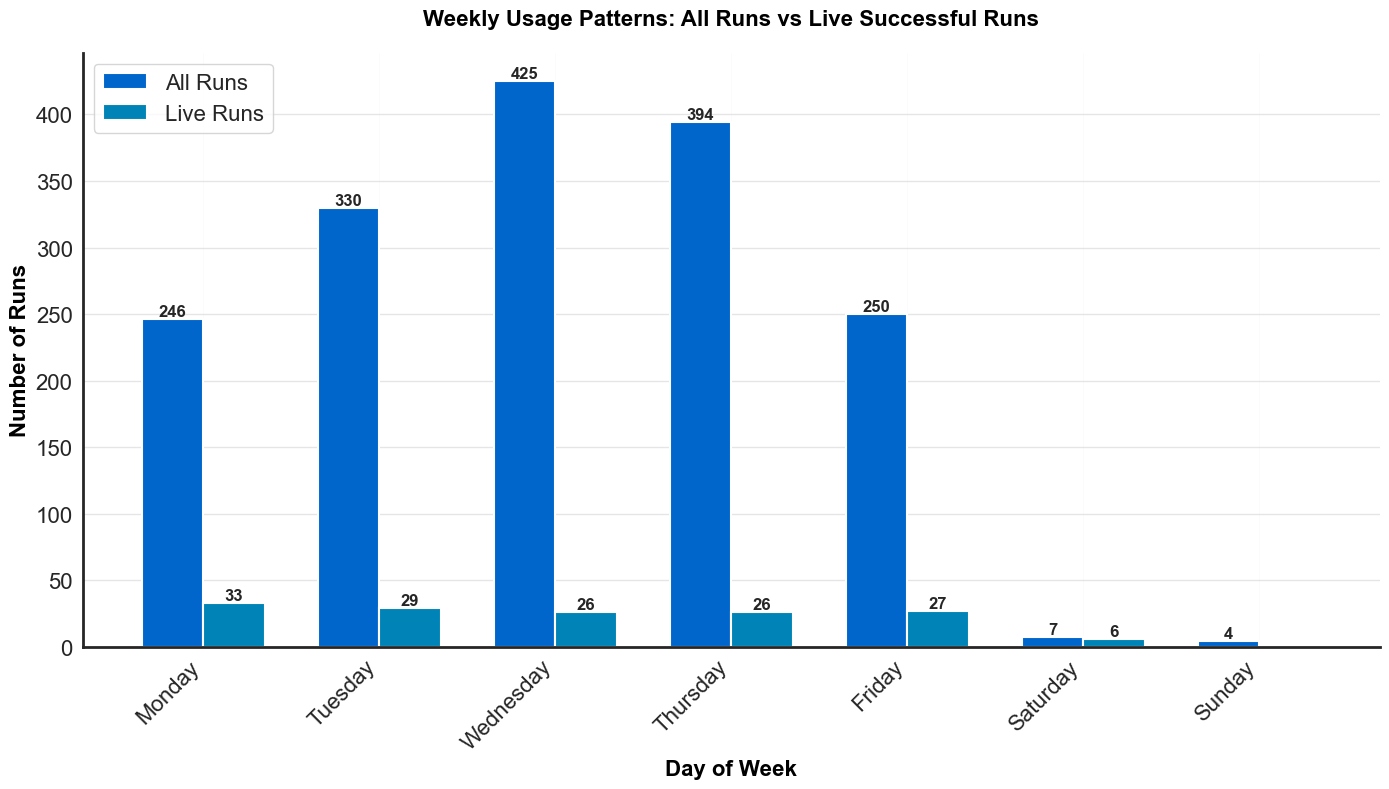

In [13]:
visual8_weekly_patterns(df,usage_live)


## Visual 8: Weekly Usage Patterns

**What the Data is Doing:**
- Function receives both `df` (merged dataframe with all data) and `usage_live` (live successful runs)
- For "All Runs": Deduplicates by `RUN_ID` from `df`, filters for `START_TIME.notna()`, extracts day of week from `START_TIME`
- For "Live Runs": Deduplicates by `RUN_ID` from `usage_live`, filters for `START_TIME.notna()`, extracts day of week from `START_TIME`
- Groups by day of week (Monday through Sunday)
- Counts unique `RUN_ID` per day of week for both datasets
- Orders days chronologically (Monday to Sunday) for proper visualization
- Creates grouped bar chart comparing "All Runs" vs "Live Runs" side-by-side

**Why This Data:**
- Day-of-week patterns reveal weekly operational cycles
- Shows if customer has consistent weekly schedules or irregular patterns
- Helps identify business operational patterns (e.g., weekday vs weekend processing)
- Compares all runs vs live runs to understand operational scope and patterns
- Separates run-level analysis to understand operational frequency

**What is the Data Set Up As:**
- **Input:** 
  - `df` (merged dataframe) - Contains all data including `START_TIME`, `RUN_ID`, `ENVIRONMENT_runs`
  - `usage_live` - Sample-level dataframe from `get_usage_live_data()` with `START_TIME`, `RUN_ID`
- **For All Runs:**
  - Deduplicates by `RUN_ID` from `df`, filters for `START_TIME.notna()`
  - Extracts day of week: `START_TIME.dt.day_name()`
- **For Live Runs:**
  - Deduplicates by `RUN_ID` from `usage_live`, filters for `START_TIME.notna()`
  - Extracts day of week: `START_TIME.dt.day_name()`
- **Grouping:** By day of week (Monday, Tuesday, ..., Sunday)
- **Aggregation:** `nunique()` of `RUN_ID` (unique runs per day) for both datasets
- **Ordering:** Days ordered chronologically (Monday to Sunday)
- **Output:** Grouped bar chart with "All Runs" and "Live Runs" as separate bars for each day

**What This Visual Shows:**
- **Grouped bar chart:**
  - X-axis: Days of week (Monday through Sunday in chronological order)
  - Y-axis: Number of unique runs
  - Two bars per day: "All Runs" and "Live Runs" side-by-side for comparison
  - Value labels on bars showing exact run counts
- Chart shows Monday through Sunday in chronological order
- Bar heights indicate volume for each day and category

**How to Interpret:**
- **Consistent across all days** = regular, 24/7 operations (good for platform engagement)
- **Higher on weekdays (Mon-Fri)** = business-hours focused operations (typical corporate pattern)
- **Higher on weekends (Sat-Sun)** = 24/7 operations or special weekend processing (may indicate research/clinical operations)
- **Irregular patterns** = ad-hoc or project-based usage (may indicate inconsistent engagement)
- **Large difference between weekdays and weekends** = business-hours focused (normal for many customers)
- **Similar weekday and weekend volumes** = continuous operations (high engagement)
- **Comparison of All Runs vs Live Runs** = shows proportion of activity that is live vs all environments
- **One day significantly higher** = may indicate scheduled batch processing or specific operational day
- **One day significantly lower** = may indicate maintenance day or operational pause
- **Weekly patterns** = reveal customer's operational model and engagement consistency

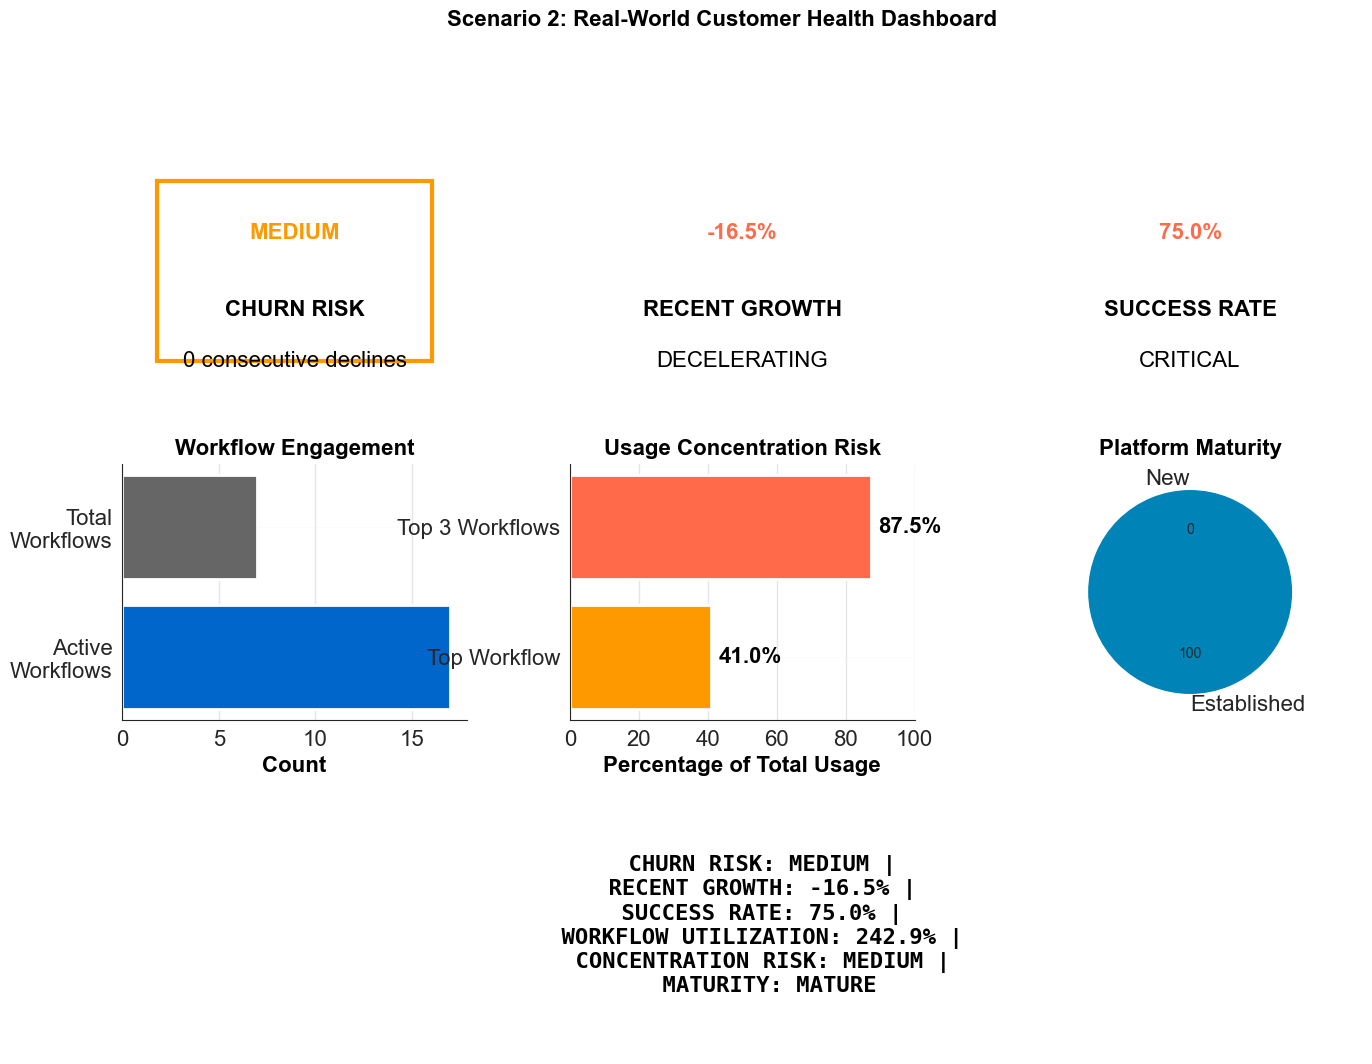

In [14]:
visual9_customer_health_dashboard(health_metrics)


## Visual 9: Customer Health Dashboard

**What the Data is Doing:**
- Uses pre-calculated `health_metrics` dictionary containing 6 metric categories
- Each metric category calculated from `usage_live` and `df`:
  - **Churn Risk:** Analyzes monthly usage trends, consecutive declines, calculates risk level
  - **Engagement:** Counts active workflows, calculates utilization and diversity index
  - **Growth:** Calculates recent and overall growth, determines acceleration/deceleration
  - **Operational Health:** Calculates success rates from run outcomes, determines status
  - **Concentration:** Analyzes workflow distribution, calculates top workflow percentages
  - **Maturity:** Calculates workflow ages, counts new vs established workflows
- Displays all metrics in a dashboard layout with color-coded indicators

**Why This Data:**
- Real-world customer success metrics provide actionable insights for account management
- Combines multiple health dimensions (churn risk, engagement, growth, operational health, concentration, maturity)
- Industry-standard metrics used by customer success teams
- Single dashboard view provides comprehensive health assessment at a glance

**What is the Data Set Up As:**
- **Input:** `health_metrics` - Dictionary with 6 keys: `churn_risk`, `engagement`, `growth`, `operational_health`, `concentration`, `maturity`
- **Source Data:** Calculated from `usage_live` (all finished LIVE samples) and `df` (merged dataframe)
- **Structure:** Each metric category contains multiple sub-metrics (e.g., `churn_risk['risk_level']`, `churn_risk['consecutive_monthly_declines']`)
- **Output:** Dashboard with 6 panels showing key metrics with color-coded risk indicators

**What This Visual Shows:**
- **6-Panel Dashboard Layout:**
  1. **Churn Risk Indicator:** Large display of risk level (HIGH/MEDIUM/LOW) with color coding, consecutive declines count
  2. **Growth Velocity:** Recent growth percentage with trajectory (ACCELERATING/DECELERATING/STABLE)
  3. **Operational Health:** Success rate percentage with operational status (HEALTHY/WARNING/CRITICAL)
  4. **Engagement Metrics:** Bar chart showing active vs total workflows, utilization percentage
  5. **Usage Concentration:** Horizontal bar chart showing top workflow and top 3 workflows percentage
  6. **Platform Maturity:** Pie chart showing new vs established workflows
- **Bottom Summary:** Text summary of all key metrics in one line

**How to Interpret:**
- **Churn Risk:** 
  - HIGH (red) = immediate action needed, customer at high risk of churning
  - MEDIUM (yellow) = monitor closely, proactive engagement recommended
  - LOW (green) = healthy customer, normal monitoring
- **Growth Velocity:**
  - Positive percentage = growth (good), negative = decline (concerning)
  - ACCELERATING = growth rate increasing (very positive)
  - DECELERATING = growth rate decreasing (concerning)
  - STABLE = consistent growth rate (neutral)
- **Operational Health:**
  - >90% success rate = HEALTHY (green)
  - 80-90% = WARNING (yellow)
  - <80% = CRITICAL (red) - requires immediate attention
- **Engagement:**
  - High utilization (>100%) = workflows being actively used
  - Low utilization = many workflows not being used
  - High diversity index (close to 1) = usage spread across many workflows (good)
- **Concentration:**
  - >50% in top workflow = HIGH risk (over-dependency)
  - 30-50% = MEDIUM risk
  - <30% = LOW risk (diversified usage)
- **Maturity:**
  - Many new workflows = growing platform (positive)
  - All established = mature platform (stable but may indicate no expansion)



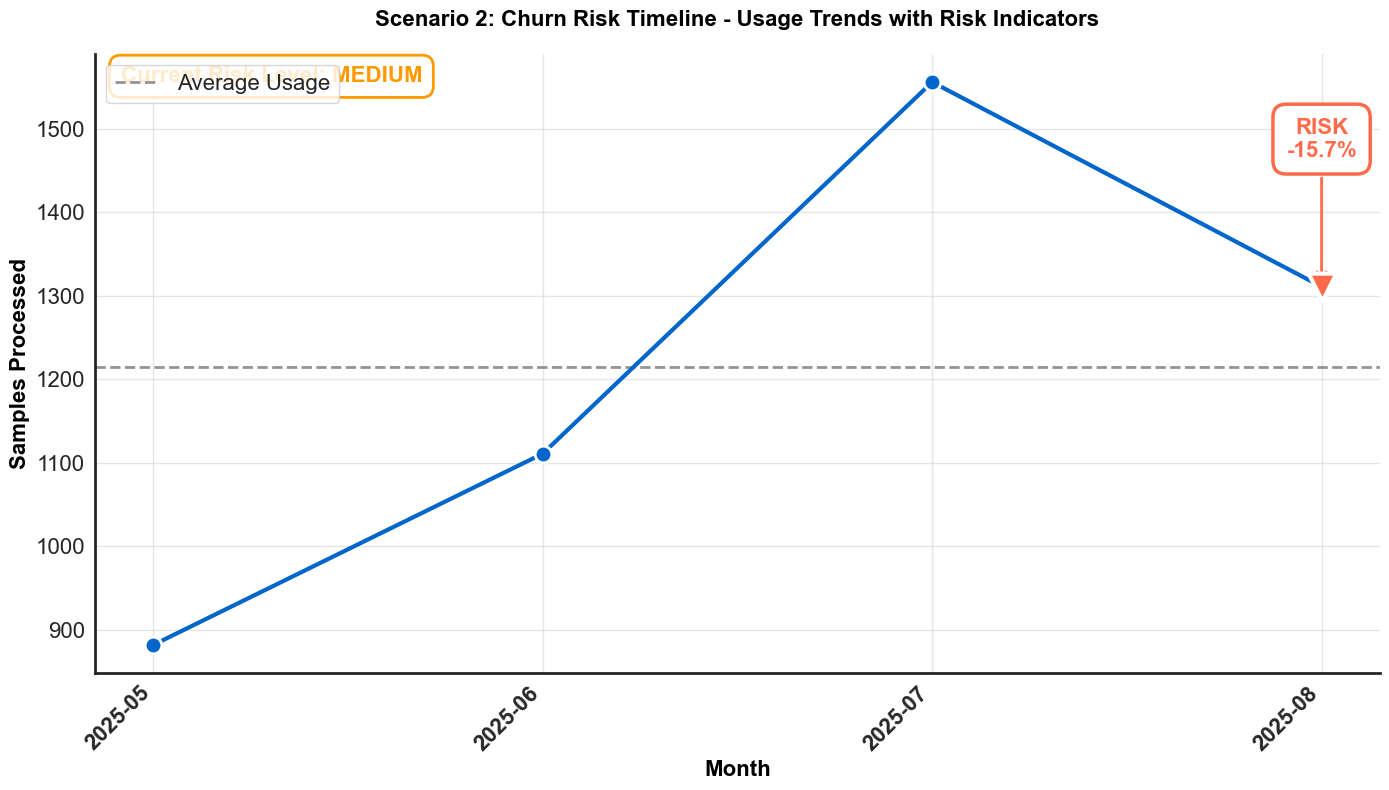

In [15]:

visual10_churn_risk_timeline(df, health_metrics)

## Visual 10: Churn Risk Timeline

**What the Data is Doing:**
- Function receives `df` (merged dataframe with all data) and filters internally to LIVE runs only (`ENVIRONMENT_runs == "live"`)
- Groups by `YEAR_MONTH`
- Counts total samples per month, calculates month-over-month percentage change
- Identifies months with >15% drops and marks them with risk indicators
- Calculates average usage across all months for baseline comparison
- Extracts current risk level from `health_metrics` for annotation

**Why This Data:**
- Monthly usage trends from merged dataframe show actual customer activity
- Health metrics provide risk level context for each period
- Timeline view reveals when risk increased/decreased over time
- Combines usage trends with risk assessment for comprehensive view

**What is the Data Set Up As:**
- **Input:** `df` (merged dataframe) - Contains all data including `YEAR_MONTH`, `RUN_ID`, `ENVIRONMENT_runs`; `health_metrics` dictionary
- **Filter Applied:** Function filters internally to `ENVIRONMENT_runs == "live"` (only LIVE runs)
- **Grouping:** By `YEAR_MONTH` (period object)
- **Aggregation:** Count of `RUN_ID` (total samples), calculation of `MOM_CHANGE_PCT`
- **Risk Detection:** Months where `MOM_CHANGE_PCT < -15` are flagged
- **Output:** Monthly time series with usage counts, MoM changes, risk markers, and average baseline

**What This Visual Shows:**
- Line chart showing monthly usage trend over time
- Red triangle markers on months with >15% drops (risk periods)
- Annotations on risk periods showing exact percentage drop
- Dashed horizontal line showing average usage across all months
- Text box showing current risk level (HIGH/MEDIUM/LOW) with color coding
- Arrow annotations pointing to risk periods with drop percentages

**How to Interpret:**
- **Drops below average line** = concerning pattern (usage below typical level)
- **Risk markers (red triangles)** = periods exceeding 15% risk threshold (immediate attention needed)
- **Current risk level** = overall assessment based on recent trends:
  - HIGH = immediate action required
  - MEDIUM = monitor closely, proactive engagement
  - LOW = healthy, normal monitoring
- **Upward trend** = positive (growing usage)
- **Downward trend** = concerning (declining usage)
- **Multiple consecutive risk markers** = escalating churn risk (very concerning)
- **Single risk marker** = isolated incident (monitor but may be temporary)
- **Risk timeline** = helps customer success team prioritize engagement timing
- **Gap between usage and average** = shows deviation from normal operations
